In [1]:
from monai import transforms as T
from glob import glob
import os
import numpy as np
import torch
from monai.transforms import LoadImage
from collections import Counter
from monai.data import ITKReader, Dataset, DataLoader

image_dir = "/cluster/projects/vc/data/mic/open/Prostate/PI-CAI-V2.0/images"
label_dir = "/cluster/projects/vc/data/mic/open/Prostate/PI-CAI-V2.0/picai_labels/csPCa_lesion_delineations/human_expert/resampled"


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
patient_folders = sorted(glob(os.path.join(image_dir, "*")))
patient_ids = [os.path.basename(folder) for folder in patient_folders]

empty = np.zeros((1024, 1024, 1024))

data = []
for patient_id in patient_ids:
    patient_folder = os.path.join(image_dir, patient_id)
    label_path = glob(os.path.join(label_dir, f"{patient_id}_*.nii.gz"))
    t2w_path = glob(os.path.join(patient_folder, "*_t2w.mha"))
    adc_path = glob(os.path.join(patient_folder, "*_adc.mha"))
    hbv_path = glob(os.path.join(patient_folder, "*_hbv.mha"))

    data_entry = {}

    if t2w_path and adc_path and hbv_path and label_path:
        data_entry = {
            "t2w": t2w_path,
            "adc": adc_path,
            "hbv": hbv_path,
            "label": label_path,
        }

        data.append(data_entry)

In [3]:
from tqdm import tqdm

load_transforms = T.Compose(
    [
        T.LoadImage(image_only=True),
        T.EnsureChannelFirst(),
    ]
)

label_transforms = T.Compose(
    [
        T.LoadImage(image_only=True),
        T.EnsureChannelFirst(),
    ]
)

batch_size = 20

image_shapes = []
label_shapes = []
intensity_stats = []
label_coverage = []


for i in tqdm(
    range(0, len(data), batch_size), desc="Loading and Processing Data", unit="batch"
):
    batch_data = data[i : i + batch_size]
    batch_t2w_images = []
    batch_label_images = []

    # Process each item in the current batch
    for item in batch_data:
        t2w_image = load_transforms(item["t2w"])
        label_image = label_transforms(item["label"])

        batch_t2w_images.append(t2w_image)
        batch_label_images.append(label_image)

    # Collect data for the current batch
    for t2w_image, label_image in zip(batch_t2w_images, batch_label_images):
        try:
            if isinstance(t2w_image, torch.Tensor):
                image = t2w_image.numpy()
            else:
                image = np.array(
                    t2w_image
                )  # Convert the list or other type to numpy array

            if isinstance(label_image, torch.Tensor):
                label = label_image.numpy()
            else:
                label = np.array(
                    label_image
                )  # Convert the list or other type to numpy array

            image_shapes.append(image.shape)
            label_shapes.append(label.shape)

            label_nonzero = np.count_nonzero(label)
            total_pixels = np.prod(label.shape)
            label_coverage.append(label_nonzero / total_pixels)

            intensity_stats.append(
                {
                    "min": image.min(),
                    "max": image.max(),
                    "mean": image.mean(),
                    "std": image.std(),
                }
            )

        except ValueError as e:
            print(f"Skipping image due to error: {e}")
            continue

# Collect statistics on the processed images
image_shapes = np.array(image_shapes)
label_shapes = np.array(label_shapes)

shape_list = [tuple(shape) for shape in image_shapes]
shape_counts = Counter(shape_list)
most_common_shape, most_common_count = shape_counts.most_common(1)[0]
total_images = len(image_shapes)
proportion = most_common_count / total_images

print("=== Dataset Overview ===")
print(f"Total images: {len(data)}")
print(f"Image Shape Range: {image_shapes.min(axis=0)} - {image_shapes.max(axis=0)}")
print(f"Label Shape Range: {label_shapes.min(axis=0)} - {label_shapes.max(axis=0)}")
print(f"Mean Image Shape: {image_shapes.mean(axis=0)}")
print(f"Median Image Shape: {np.median(image_shapes, axis=0)}")
print(f"Most Common Shape: {most_common_shape}")
print(f"Occurrences: {most_common_count}")
print(f"Proportion: {proportion:.2%}")

label_coverage = np.array(label_coverage)
print(
    f"Label Coverage (Mean): {label_coverage.mean():.4f}, Range: {label_coverage.min():.4f} - {label_coverage.max():.4f}"
)
print(
    f"Intensity Min: {np.min([s['min'] for s in intensity_stats])}, Max: {np.max([s['max'] for s in intensity_stats])}"
)
print(
    f"Mean Intensity: {np.mean([s['mean'] for s in intensity_stats])} ± {np.std([s['mean'] for s in intensity_stats])}"
)


Loading and Processing Data:   0%|          | 0/64 [00:00<?, ?batch/s]

Loading and Processing Data:   8%|▊         | 5/64 [01:01<10:42, 10.88s/batch]

Skipping image due to error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (2, 1, 640, 640) + inhomogeneous part.
Skipping image due to error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (2, 1, 384, 384) + inhomogeneous part.


Loading and Processing Data:  11%|█         | 7/64 [01:18<08:58,  9.45s/batch]

Skipping image due to error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (2, 1, 384, 384) + inhomogeneous part.


Loading and Processing Data:  27%|██▋       | 17/64 [02:54<07:07,  9.09s/batch]

Skipping image due to error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (2, 1, 384, 384) + inhomogeneous part.


Loading and Processing Data:  38%|███▊      | 24/64 [04:02<06:56, 10.40s/batch]

Skipping image due to error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (2, 1, 384, 384) + inhomogeneous part.


Loading and Processing Data:  42%|████▏     | 27/64 [04:32<06:12, 10.08s/batch]

Skipping image due to error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (2, 1, 640, 640) + inhomogeneous part.
Skipping image due to error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (2, 1, 768, 768) + inhomogeneous part.


Loading and Processing Data:  70%|███████   | 45/64 [07:24<02:58,  9.37s/batch]

Skipping image due to error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 1) + inhomogeneous part.


Loading and Processing Data:  72%|███████▏  | 46/64 [07:35<02:58,  9.94s/batch]

Skipping image due to error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (2, 1, 384, 384) + inhomogeneous part.


Loading and Processing Data:  92%|█████████▏| 59/64 [11:52<00:46,  9.36s/batch]

Skipping image due to error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 1) + inhomogeneous part.


Loading and Processing Data: 100%|██████████| 64/64 [12:35<00:00, 11.80s/batch]

=== Dataset Overview ===
Total images: 1272
Image Shape Range: [  1   1 256 256  17] - [   3    1 1024 1024   45]
Label Shape Range: [  1   1 256 256  17] - [   3    1 1024 1024   45]
Mean Image Shape: [  1.0110935    1.         553.78763867 553.78763867  22.68066561]
Median Image Shape: [  1.   1. 384. 384.  21.]
Most Common Shape: (1, 1, 1024, 1024, 27)
Occurrences: 196
Proportion: 15.53%
Label Coverage (Mean): 0.0001, Range: 0.0000 - 0.0072
Intensity Min: 0.0, Max: 4095.0
Mean Intensity: 194.73764038085938 ± 83.35468292236328


In [29]:
class ConvertToBinaryLabeld(T.MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key in data:
                label = d[key]  # Extract label tensor

                # Convert to binary: 0 for ISUP ≤1, 1 for ISUP ≥2
                d[key] = (label >= 1).float()

        return d


class ZScoreNormalizeD(T.MapTransform):
    """
    Custom MONAI transform for instance-wise Z-score normalization.
    This normalizes each image by subtracting the mean and dividing by the standard deviation.
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key in d:
                img = d[key]

                mean = torch.mean(img)
                std = torch.std(img)

                if std > 0:
                    d[key] = (img - mean) / std
                else:
                    d[key] = img

        return d


class StackImages(T.MapTransform):
    def __init__(self, keys: list):
        super().__init__(keys)

    def __call__(self, data: dict):
        # Retrieve the images for t2w, adc, hbv
        t2w = data["t2w"]
        adc = data["adc"]
        hbv = data["hbv"]

        # Stack them into a single 3D tensor (channels last)
        stacked_image = torch.stack([t2w, adc, hbv], dim=0)

        # Add the stacked image to the dictionary
        data["image"] = stacked_image.squeeze()

        return data

In [30]:
default_preprocess = T.Compose(
    [
        T.LoadImaged(keys=["t2w", "adc", "hbv", "label"], reader=ITKReader),
        T.EnsureChannelFirstd(keys=["t2w", "adc", "hbv", "label"]),
        T.ResampleToMatchd(
            keys=["adc", "hbv"],
            key_dst="t2w",
            mode="bilinear",
            padding_mode="border",
        ),
        T.Orientationd(keys=["t2w", "adc", "hbv", "label"], axcodes="RAS"),
        T.Spacingd(
            keys=["t2w", "adc", "hbv", "label"],
            pixdim=(0.5, 0.5, 1.2),
            mode=("bilinear", "bilinear", "bilinear", "nearest"),
        ),
        T.NormalizeIntensityd(keys=["adc"], channel_wise=False),
        ZScoreNormalizeD(keys=["t2w", "hbv"]),
        T.Resized(
            keys=["t2w", "adc", "hbv", "label"],
            spatial_size=[512, 512, 32],
            mode=("area", "area", "area", "nearest"),
        ),
        ConvertToBinaryLabeld(keys=["label"]),
    ]
)

In [31]:
num_samples = 1
augment = T.Compose(
    [
        T.RandCropByLabelClassesd(
            keys=["t2w", "adc", "hbv", "label"],
            label_key="label",
            spatial_size=[256, 256, 32],
            num_classes=2,
            num_samples=1,
            ratios=[0.1, 1],
        ),
        StackImages(keys=["t2w", "adc", "hbv"]),
        T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    ]
)

In [32]:
transform = T.Compose([default_preprocess, augment])

In [33]:
final_data = transform(data[0:10])


In [26]:
loader = T.LoadImaged(keys=["t2w", "adc", "hbv", "label"], reader=ITKReader)
loaded_data = [loader(d) for d in data[:10]]

torch.Size([3, 256, 256, 32])
torch.Size([3, 256, 256, 32])
torch.Size([3, 256, 256, 32])
torch.Size([3, 256, 256, 32])
torch.Size([3, 256, 256, 32])


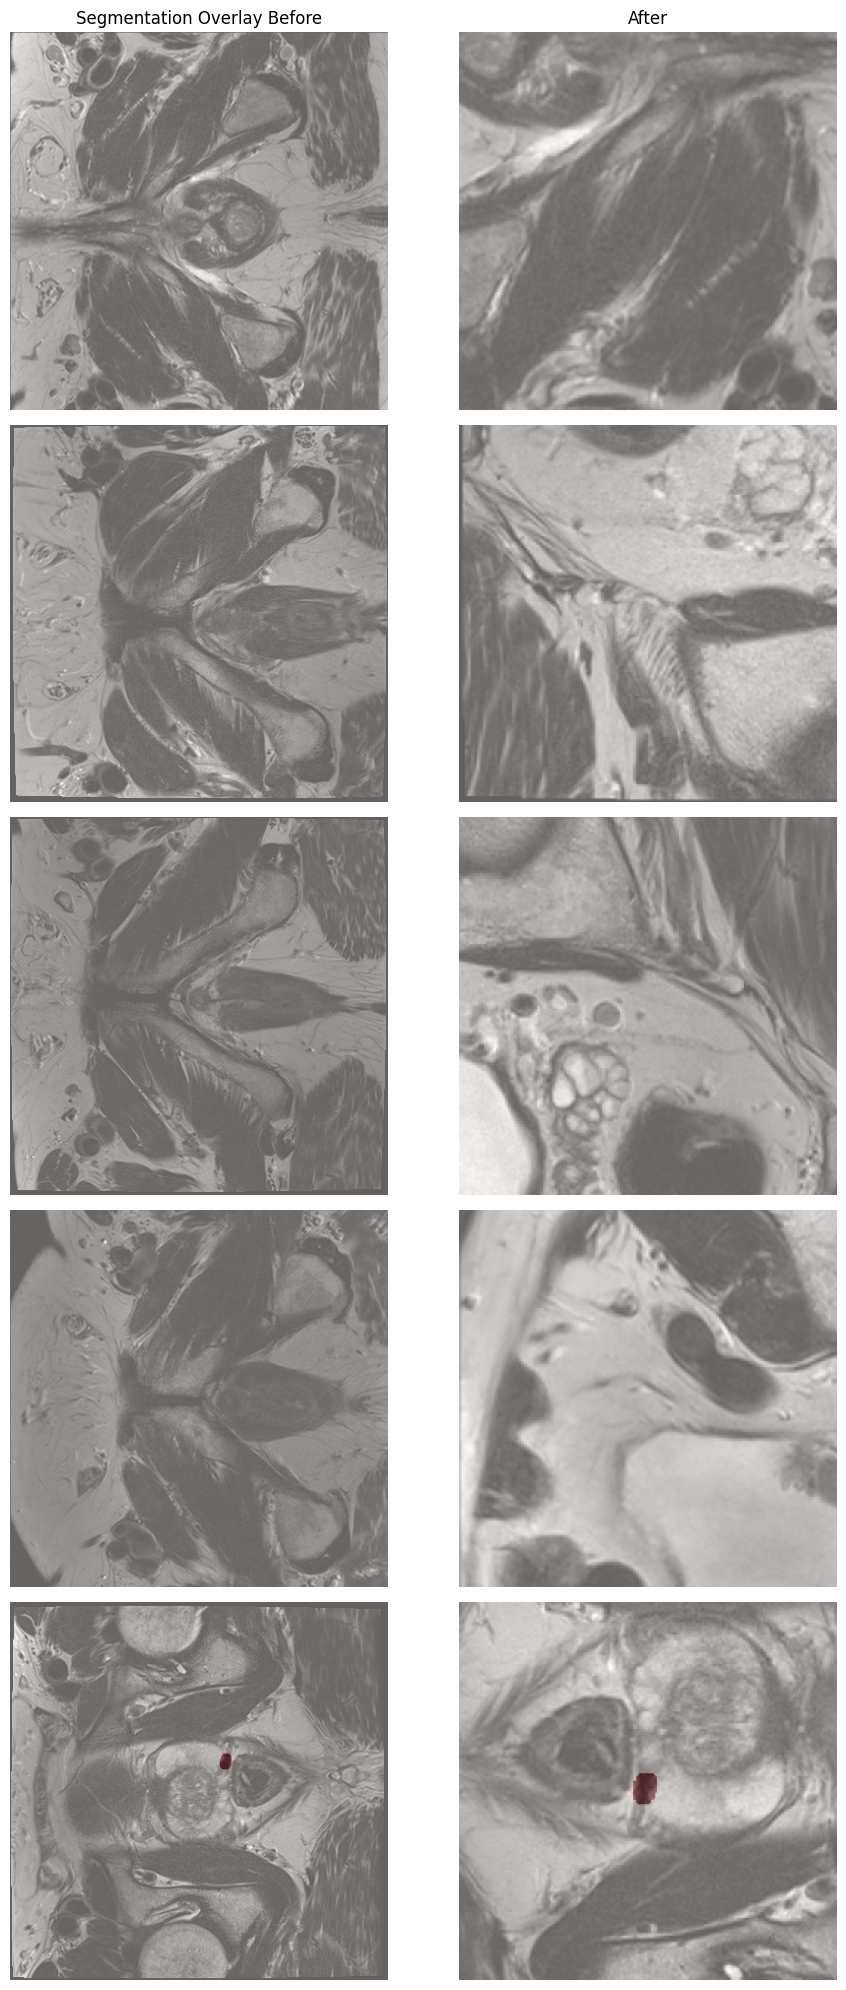

In [35]:
import matplotlib.pyplot as plt

n = 5

fig, axes = plt.subplots(n, num_samples + 1, figsize=(10, 20))

axes[0, 0].set_title("Segmentation Overlay Before")
axes[0, 1].set_title("After")

for i in range(n):
    sample = loaded_data[i]

    label_slices = np.sum(sample["label"], axis=(0, 1))
    slice = np.argmax(label_slices)

    axes[i, 0].imshow(sample["t2w"][:, :, slice], cmap="gray")
    axes[i, 0].imshow(sample["label"][:, :, slice], cmap="Reds", alpha=0.4)
    axes[i, 0].axis("off")

    for j in range(num_samples):  # Loop over augmented versions
        label_slices_final = np.sum(final_data[i][j]["label"][0], axis=(0, 1))
        slice_final = np.argmax(label_slices_final)
        print(final_data[i][j]["image"].shape)
        axes[i, j + 1].imshow(
            final_data[i][j]["image"][0, :, :, slice_final], cmap="gray"
        )
        axes[i, j + 1].imshow(
            final_data[i][j]["label"][0, :, :, slice_final], cmap="Reds", alpha=0.4
        )
        axes[i, j + 1].axis("off")


plt.tight_layout()
plt.show()

torch.Size([3, 256, 256, 32])
torch.Size([3, 256, 256, 32])
torch.Size([3, 256, 256, 32])
torch.Size([3, 256, 256, 32])
torch.Size([3, 256, 256, 32])


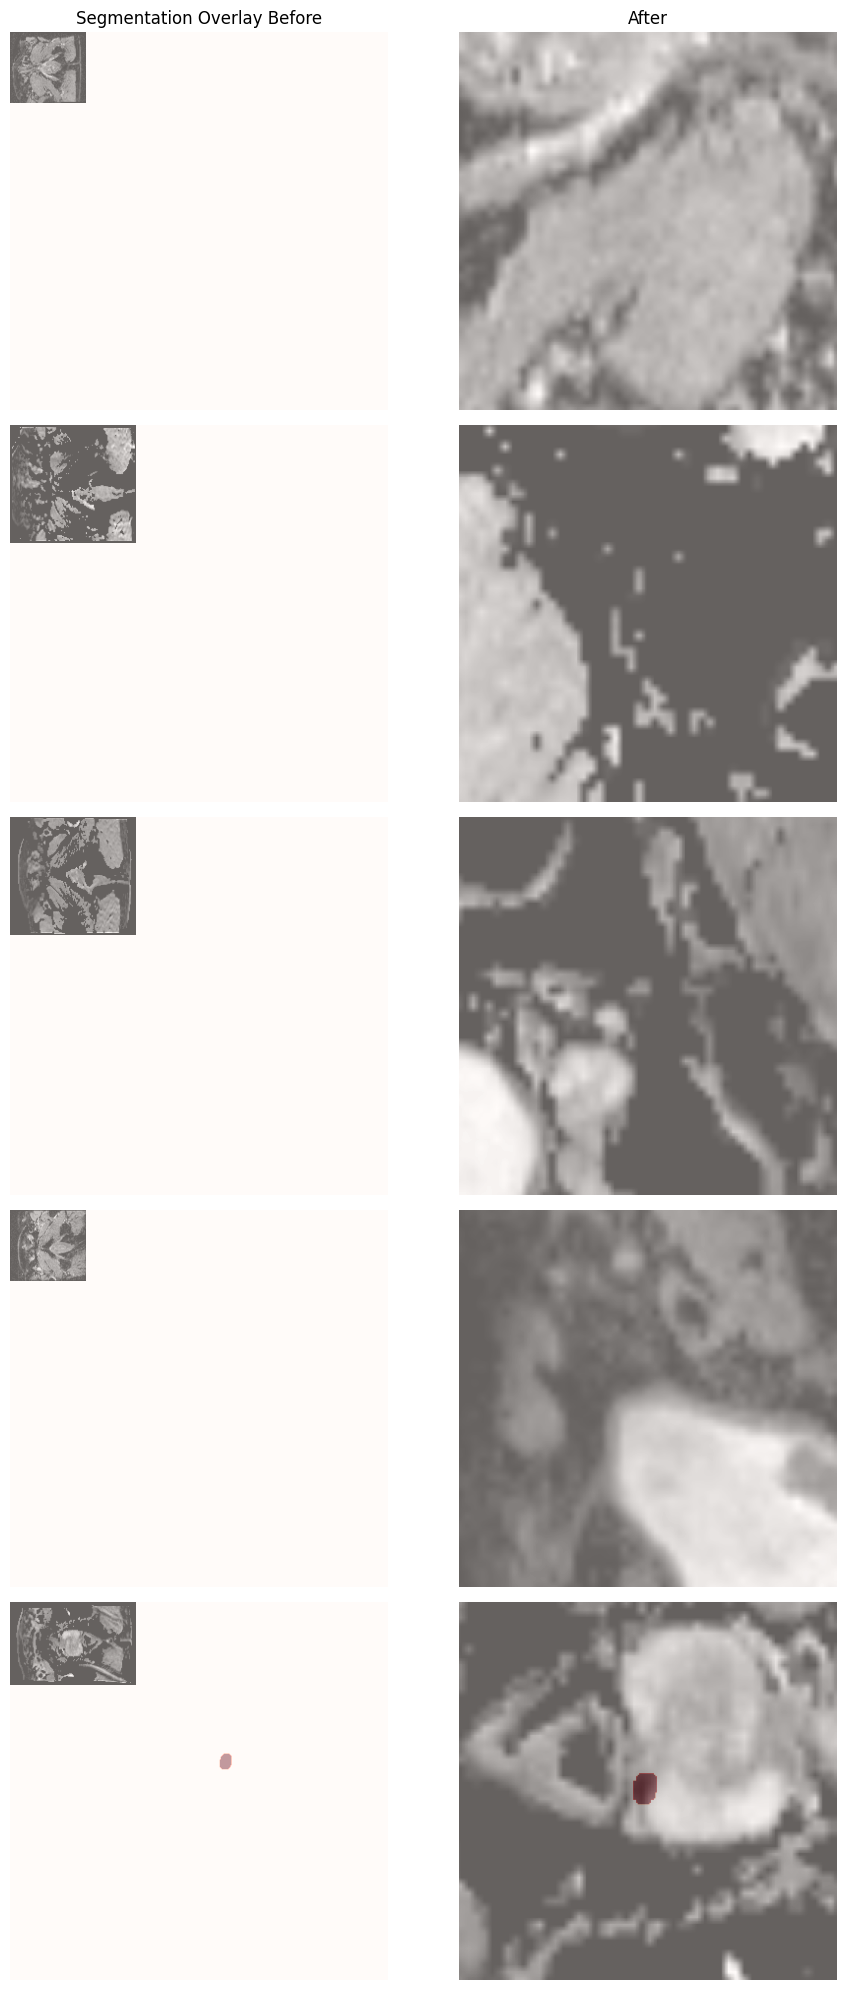

In [36]:
import matplotlib.pyplot as plt

n = 5

fig, axes = plt.subplots(n, num_samples + 1, figsize=(10, 20))

axes[0, 0].set_title("Segmentation Overlay Before")
axes[0, 1].set_title("After")

for i in range(n):
    sample = loaded_data[i]

    label_slices = np.sum(sample["label"], axis=(0, 1))
    slice = np.argmax(label_slices)

    axes[i, 0].imshow(sample["adc"][:, :, slice], cmap="gray")
    axes[i, 0].imshow(sample["label"][:, :, slice], cmap="Reds", alpha=0.4)
    axes[i, 0].axis("off")

    for j in range(num_samples):  # Loop over augmented versions
        label_slices_final = np.sum(final_data[i][j]["label"][0], axis=(0, 1))
        slice_final = np.argmax(label_slices_final)
        print(final_data[i][j]["image"].shape)
        axes[i, j + 1].imshow(
            final_data[i][j]["image"][1, :, :, slice_final], cmap="gray"
        )
        axes[i, j + 1].imshow(
            final_data[i][j]["label"][0, :, :, slice_final], cmap="Reds", alpha=0.4
        )
        axes[i, j + 1].axis("off")


plt.tight_layout()
plt.show()

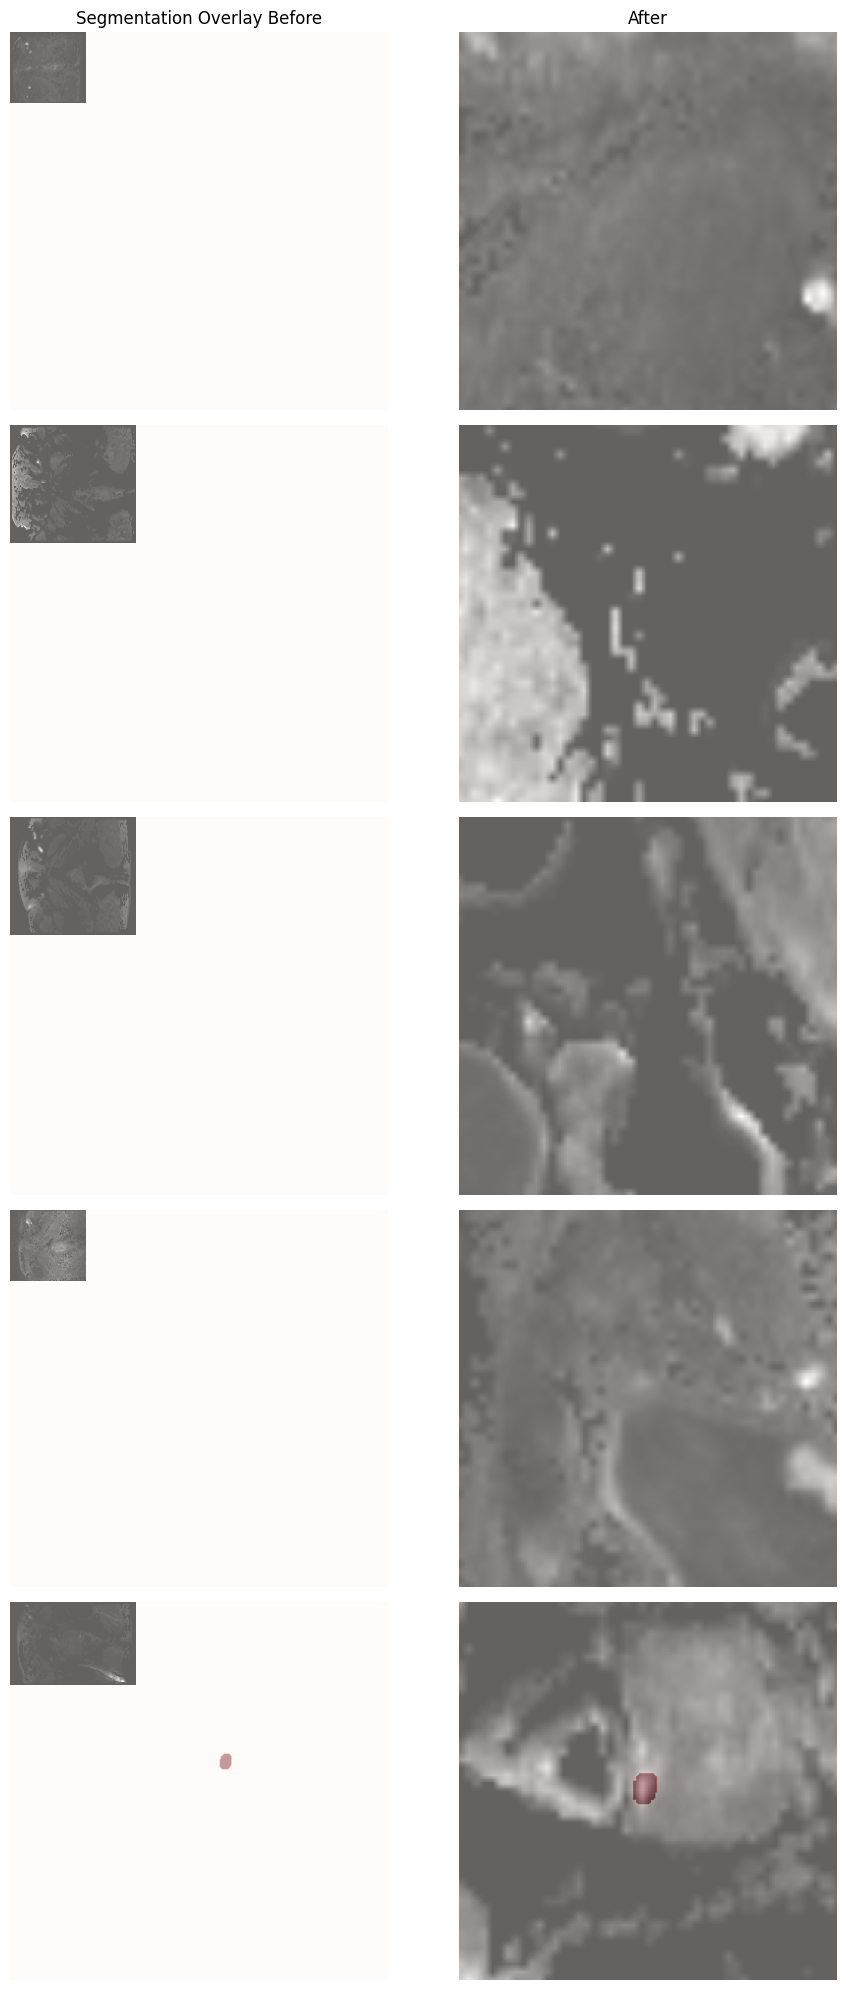

In [37]:
n = 5

fig, axes = plt.subplots(n, num_samples + 1, figsize=(10, 20))

axes[0, 0].set_title("Segmentation Overlay Before")
axes[0, 1].set_title("After")

for i in range(n):
    sample = loaded_data[i]

    label_slices = np.sum(sample["label"], axis=(0, 1))
    slice = np.argmax(label_slices)

    axes[i, 0].imshow(sample["hbv"][:, :, slice], cmap="gray")
    axes[i, 0].imshow(sample["label"][:, :, slice], cmap="Reds", alpha=0.4)
    axes[i, 0].axis("off")

    for j in range(num_samples):  # Loop over augmented versions
        label_slices_final = np.sum(final_data[i][j]["label"][0], axis=(0, 1))
        slice_final = np.argmax(label_slices_final)

        axes[i, j + 1].imshow(
            final_data[i][j]["image"][2, :, :, slice_final], cmap="gray"
        )
        axes[i, j + 1].imshow(
            final_data[i][j]["label"][0, :, :, slice_final], cmap="Reds", alpha=0.4
        )
        axes[i, j + 1].axis("off")


plt.tight_layout()
plt.show()